# Dataset exploration

In this notebook, we will explore several basic statistics of the dataset used in the research, such as the number of streams, documents in the pages, as well as showing distribution plots for these variables.

## Index

1. [General Statistics](#ref1)
    - 1.1 [Basic Statistics Table](#ref2)
    - 1.2 [KDE Plots](#ref3)

In [16]:
import os
import math
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Local imports
%run ../utils/metricutils.py

In [17]:
train_dataframe = pd.read_csv('../data/dataframes/train.csv')
test_dataframe = pd.read_csv('../data/dataframes/test.csv')

complete_dataframe = pd.concat([train_dataframe, test_dataframe])

<a id="ref1" />

## General Statistics

For the first part of the comparison of the different datasets, we will just report some basic statistics such as the number of streams and the number of pages and documents, etc. We will also go into a bit more detail by showing some distribution plots of the sizes of the documents and streams (where applicable).

In [18]:
def get_general_statistics(dataframe) -> pd.DataFrame:
    number_of_streams = dataframe.name.nunique()
    number_of_documents = dataframe.label.sum() # number of documents is number of ones in label column in binary format.
    number_of_pages = dataframe.shape[0]
    
    # Get the percentage of singleton documents in the daseset.
    ground_truth_dict = get_ground_truth_from_dataframe(dataframe, col="label")
    # Convert the dict to the length list format to easily get the percentage of singletons
    length_list_ground_truth_dict = {key: bin_to_length_list(val) for key, val in ground_truth_dict.items()}
    all_document_lengths = pd.Series(item for val in length_list_ground_truth_dict.values() for item in val)
    percentage_singletons = (all_document_lengths == 1).mean()
    num_pages_in_document = None
    num_documents_in_streams = pd.Series([len(value) for value in length_list_ground_truth_dict.values()])
    num_pages_in_streams = pd.Series([sum(value) for value in length_list_ground_truth_dict.values()])
    
    # finally, we will set the dtypes of the columns to the appropriate type
    
    return pd.Series({'Number of Streams':number_of_streams,
                      'Number of Documents': number_of_documents,
                      "Number of Pages": number_of_pages,
                      "Percentage of Singletons": round(percentage_singletons, 2),
                     'Median Number of Pages in Stream': num_pages_in_streams.median(),
                     'Median Number of Documents in Stream': num_documents_in_streams.median()})

<a id="ref2" />

### Table with general statistics

First we wil create a simple table with some of the general statistics of all of the datasets.

In [20]:
# Generate the general statistics for all datasets and put them into one pandas dataframe

dataset_statistics_full = get_general_statistics(complete_dataframe)
dataset_statistics_train = get_general_statistics(train_dataframe)
dataset_statistics_test = get_general_statistics(test_dataframe)

all_datasets_general_statistics = pd.DataFrame({'Complete Dataset': dataset_statistics_full,
                                               'Train Dataset': dataset_statistics_train,
                                               'Test Dataset': dataset_statistics_test}).T.astype({'Number of Streams': 'int',
                                                                             'Number of Documents': 'int',
                                                                             'Number of Pages': 'int',
                                                                               'Median Number of Pages in Stream': 'int',
                                                                               'Median Number of Documents in Stream': 'int'})

all_datasets_general_statistics

,Number of Streams,Number of Documents,Number of Pages,Percentage of Singletons,Median Number of Pages in Stream,Median Number of Documents in Stream
Complete Dataset,110,24181,89491,0.30,217,55
Train Dataset,76,17834,63815,0.30,202,55
Test Dataset,34,6347,25676,0.28,331,57


Please note here that tobacco does actually not have the concept of streams, so the number of streams and average number of pages in stream numbers are not really meaningful. The above numbers already show some interesting things, mostly about the percentage of singletons and the average number of pages in a stream. We see that the percentage of singletons for for C1 and C2 is very similar, and that for AI lab splitter it is a bit higher, and quite a bit higher for Tobacco. The most interesting observation however, is the large difference in the average number of pages in a stream, with the C1 dataset having by far the largest number (tobacco800 excluded as it is just one stream). Also, we see that the AI LAB splitter contains streams that are quite short, with only 17 pages in a stream.

<a id="ref3" />

### Kernel Denstiy Estimation Plots

Apart from just a table with the raw statistics of the datasets, we will also plot some distributions, namely of the number of clusters in a stream, and the number of pages in a document, which will give as some more interesting and visual insights into the differences between the datasets.

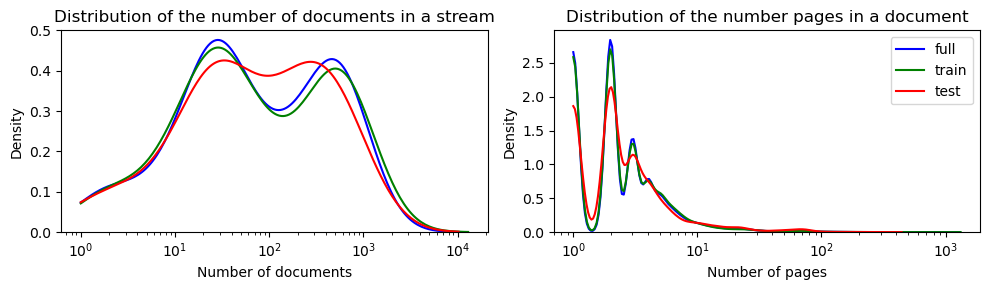

In [ ]:
color_map = {'full': 'blue', 'train': 'green', 'test': 'red'}
fig, ax = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(10, 3))
for i, (name, dataframe) in enumerate({'full': complete_dataframe, 'train': train_dataframe, 'test': test_dataframe}.items()):
    page_labels = get_ground_truth_from_dataframe(dataframe, col="label")
    # Convert the dict to the length list format to easily get the percentage of singletons
    length_list_streams = {key: bin_to_length_list(val) for key, val in page_labels.items()}
    stream_lengths = [len(item) for item in length_list_streams.values() if len(item)]
    document_lengths = [pages for document in length_list_streams.values() for pages in document]
    if name != 'TOBACCO':
        sns.kdeplot(data=stream_lengths, ax=ax[0], log_scale=True, label=name, color=color_map[name], clip=[0, 1228])
    sns.kdeplot(data=document_lengths, ax=ax[1], log_scale=True, label=name, color=color_map[name], clip=[0, 962])

ax[0].set_title("Distribution of the number of documents in a stream")
ax[0].set_xlabel("Number of documents")
ax[1].set_title("Distribution of the number pages in a document")
ax[1].set_xlabel("Number of pages")
plt.legend()
plt.tight_layout()
plt.show()

    

TODO: Even klooien met die smoothing van de KDE in de plotjes, er zit nu een vreemde dip in de distributie tussen 1 en 2, dat is natuurlijk een beetje vreemd voor discrete variabelen.

Studying the above plots, we can see some interesting differences,as the large difference between the distribution of the number of documents in a stream between the C1, C2 corpora and the AILAB dataset. We also see fairly similar distribution for all datasets regarding the number of pages in a document, where there is a large number of documents that has only a single page, and the percentage of documents that has more than $n$ pages quickly drops after this.

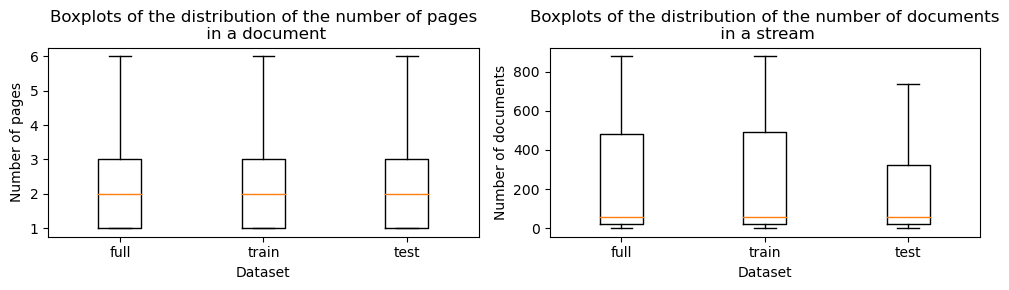

In [25]:
# TODO: make multiple nice boxplots to show this.
document_lengths_dict = {}
stream_lengths_dict = {}
for i, (name, dataframe) in enumerate({'full': complete_dataframe, 'train': train_dataframe, 'test': test_dataframe}.items()):
    page_labels = get_ground_truth_from_dataframe(dataframe, col="label")
    # Convert the dict to the length list format to easily get the percentage of singletons
    length_list_streams = {key: bin_to_length_list(val) for key, val in page_labels.items()}
    stream_lengths = [len(item) for item in length_list_streams.values() if len(item)]
    document_lengths = [pages for document in length_list_streams.values() for pages in document]
    document_lengths_dict[name] = document_lengths
    if name != 'TOBACCO':
        stream_lengths_dict[name] = stream_lengths

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
# document length boxplots
ax[0].boxplot(document_lengths_dict.values(), sym='')
ax[0].set_xticklabels(document_lengths_dict.keys())
# Stream length boxplots
ax[1].boxplot(stream_lengths_dict.values(), sym='')
ax[1].set_xticklabels(stream_lengths_dict.keys())
ax[0].set_xlabel("Dataset")
ax[1].set_xlabel("Dataset")

ax[0].set_title("Boxplots of the distribution of the number of pages\n in a document")
ax[1].set_title("Boxplots of the distribution of the number of documents\n in a stream")

ax[0].set_ylabel("Number of pages")
ax[1].set_ylabel("Number of documents")

plt.tight_layout()
plt.savefig('boxplots_distributions.png')
plt.show()